### Task 4 - Soil erosion detection

In this task I just deal with given data without making predictions on it

But if I could train the model I would do it like this:

We want to predict for an arbitrary satellite image the size and location of the erosion spots. To do this, I would divide the training data into much smaller square blocks. I would pass each small block through a neural network, which would return the probability of erosion formation on a specific pixel of a small area. This neural network could train on the data of one large image, divided into many small ones.
Given that erosion spots occur in groups, I would divide the train data in such a way that there would be more examples of erosion than there really are.


In [3]:
!pip install rasterio
!pip install pandas
!pip install geopandas
!pip install numpy
!pip install opencv-python
!pip install matplotlib
!pip install shapely

import os

import rasterio
from rasterio.plot import reshape_as_image
import rasterio.mask
from rasterio.features import rasterize

import pandas as pd
import geopandas as gpd
from shapely.geometry import mapping, Point, Polygon
from shapely.ops import cascaded_union

import numpy as np
import cv2
import matplotlib.pyplot as plt

%matplotlib inline

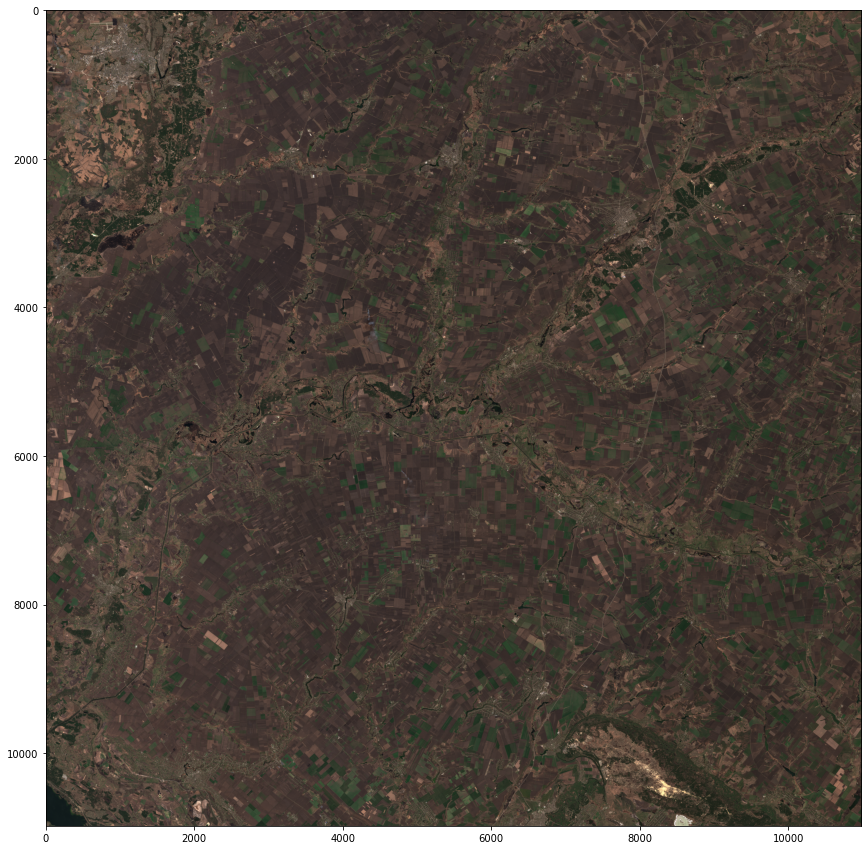

In [6]:
raster_path = 'T36UXV_20200406T083559_TCI_10m.jp2'
with rasterio.open(raster_path, "r", driver="JP2OpenJPEG") as src:
    raster_img = src.read()
    raster_meta = src.meta

raster_img = reshape_as_image(raster_img)
plt.figure(figsize=(15,15))
plt.imshow(raster_img)

In [41]:
train_df = gpd.read_file("Masks/Masks_T36UXV_20190427.shp")
train_df['geometry'][0].exterior.coords.xy

(array('d', [35.62916346617293, 35.63014960535702, 35.631175190108465, 35.631214635675825, 35.630031268654925, 35.62888734720139, 35.62813788142149, 35.62774342574785, 35.62813788142149, 35.62916346617293]),
 array('d', [49.602931546762534, 49.60162984303954, 49.60080148612491, 49.59981534694083, 49.6001703570471, 49.60111705066382, 49.60214263541526, 49.60289210119517, 49.60312877459935, 49.602931546762534]))

Here we can recieve coordicantes on google maps: 49.6, 35.6

Now let's converting GeoDataframe to raster

In [37]:
train_df = gpd.read_file("Masks/Masks_T36UXV_20190427.shp")

train_df = train_df[train_df.geometry.notnull()]

train_df.crs = {'init' :'epsg:4326'} # traditional 0-coordinate

train_df = train_df.to_crs({'init' : raster_meta['crs']['init']})

/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


Now let's cut fields from raster, that contains erosion


In [38]:
src = rasterio.open(raster_path, 'r', driver="JP2OpenJPEG")
outfolder = "article"
os.makedirs(outfolder, exist_ok=True)
failed = []
for num, row in train_df.iterrows():
    try:
        masked_image, out_transform = rasterio.mask.mask(src, [mapping(row['geometry'])], crop=True, nodata=0)
        img_image = reshape_as_image(masked_image)
        img_path = os.path.join(outfolder, str(row['Field_Id']) + '.png')
        img_image = cv2.cvtColor(img_image, cv2.COLOR_RGB2BGR)
        cv2.imwrite(img_path, img_image)
    except Exception as e:
#         print(e)
        failed.append(num)
print("Rasterio failed to mask {} files".format(len(failed)))

Rasterio failed to mask 935 files


In [ ]:
def poly_from_utm(polygon, transform):
    poly_pts = []
    
    # make a polygon from multipolygon
    poly = cascaded_union(polygon)
    for i in np.array(poly.exterior.coords):
        
        # transfrom polygon to image crs, using raster meta
        poly_pts.append(~transform * tuple(i))
        
    # make a shapely Polygon object
    new_poly = Polygon(poly_pts)
    return new_poly

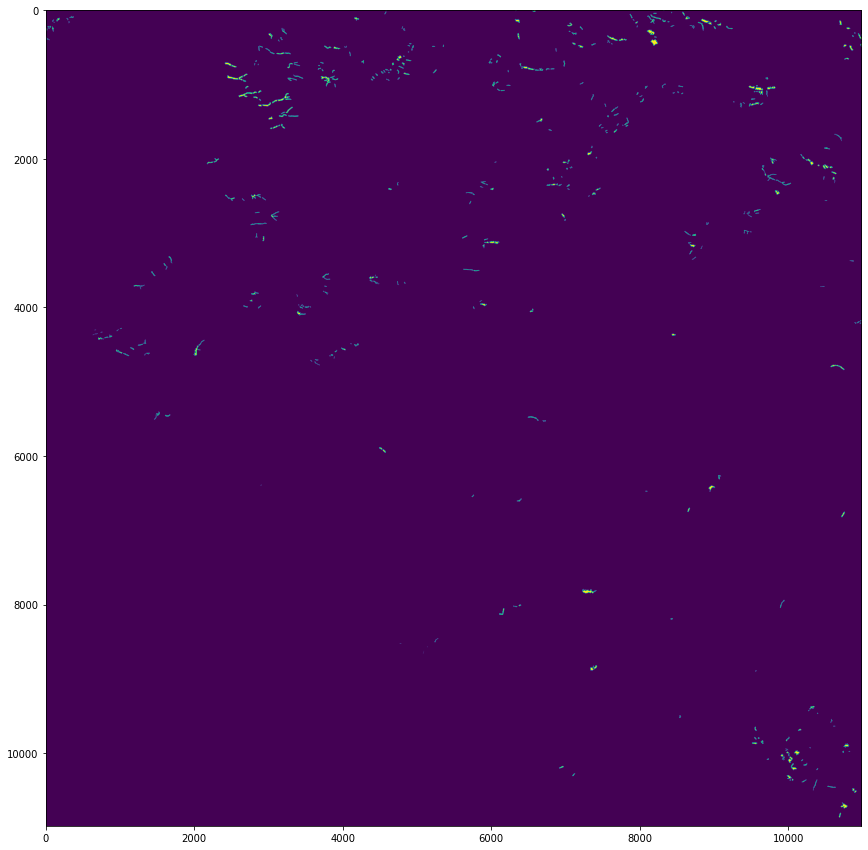

In [39]:
poly_shp = []
im_size = (src.meta['height'], src.meta['width'])
for num, row in train_df.iterrows():
    if row['geometry'].geom_type == 'Polygon':
        poly = poly_from_utm(row['geometry'], src.meta['transform'])
        poly_shp.append(poly)
    else:
        for p in row['geometry']:
            poly = poly_from_utm(p, src.meta['transform'])
            poly_shp.append(poly)

mask = rasterize(shapes=poly_shp,
                 out_shape=im_size)

# plotting the mask

plt.figure(figsize=(15,15))
plt.imshow(mask)